In [1]:
# https://www.kaggle.com/mlg-ulb/creditcardfraud
# pip install -U imbalanced-learn
# conda install -c conda-forge imbalanced-learn


from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
dfData = pd.read_csv("creditcard.csv")
y = dfData["Class"]
dfData = dfData.drop("Class",axis=1)
X = dfData.copy()

In [2]:
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in stratSplit.split(X, y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

In [3]:
print("Label distribution:\n", y_train.value_counts()/y_train.count()*100)
print("Number of instances:", y_train.count())

Label distribution:
 0    99.827075
1     0.172925
Name: Class, dtype: float64
Number of instances: 227845


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

def crossValData(X_train, y_train):
    log_reg = LogisticRegression(C=1e5)

    results = cross_validate(log_reg,
                             X = X_train,
                             y = y_train,
                             scoring = ["accuracy", "recall", "f1", "roc_auc"],#no need for macro or so here, only 2 labels
                             #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                             cv = 3,
                             n_jobs = -1,
                             verbose = True,
                             return_train_score = True,
                             return_estimator = True)
    return results

results = crossValData(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished


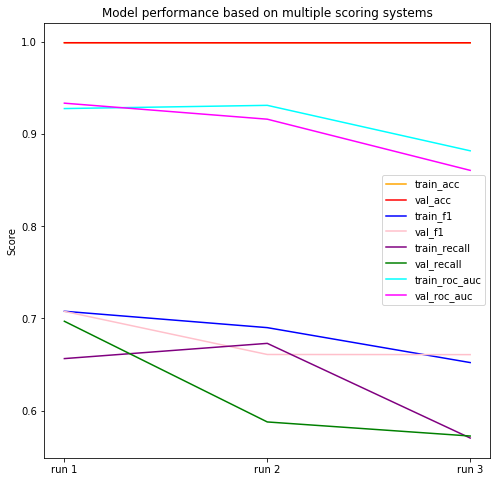

In [5]:
import matplotlib.pyplot as plt
def visualizeResults(results):
    cvData = {"val_f1":results["test_f1"],
            "train_f1":results["train_f1"],
            "val_recall":results["test_recall"],
            "train_recall":results["train_recall"],
            "val_acc":results["test_accuracy"],
            "train_acc":results["train_accuracy"],
            "val_roc_auc":results["test_roc_auc"],
            "train_roc_auc":results["train_roc_auc"]}

    dfCV = pd.DataFrame(cvData)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot()
    plt.plot(dfCV.index,dfCV["train_acc"],label="train_acc", color="orange")
    plt.plot(dfCV.index,dfCV["val_acc"],label="val_acc", c="r")
    plt.plot(dfCV.index,dfCV["train_f1"],label="train_f1", c="b")
    plt.plot(dfCV.index,dfCV["val_f1"],label="val_f1", c="pink")
    plt.plot(dfCV.index,dfCV["train_recall"],label="train_recall", c="purple")
    plt.plot(dfCV.index,dfCV["val_recall"],label="val_recall", c="g")
    plt.plot(dfCV.index,dfCV["train_roc_auc"],label="train_roc_auc", c="cyan")
    plt.plot(dfCV.index,dfCV["val_roc_auc"],label="val_roc_auc", c="magenta")
    plt.legend()
    plt.ylabel("Score")
    plt.title("Model performance based on multiple scoring systems")
    plt.xticks(range(len(results["fit_time"])),["run "+str(i+1) for i in range(len(results["fit_time"]))])
    plt.show()
visualizeResults(results)

Label distribution: 1    50.0
0    50.0
Name: Class, dtype: float64
Number of instances: 788


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


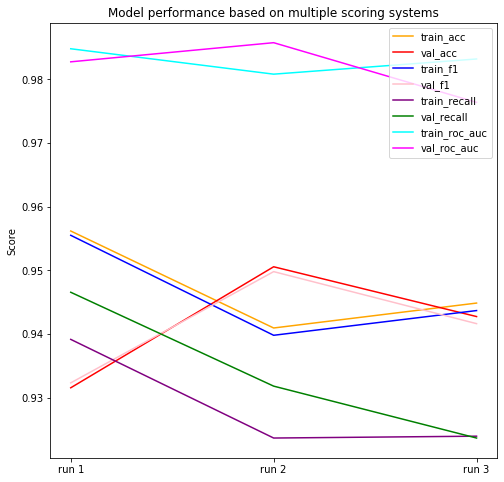

In [6]:
from imblearn.under_sampling import RandomUnderSampler
#undersample majority class to create equal distribution of classes
rand_res = RandomUnderSampler()
X_train_res, y_train_res = rand_res.fit_resample(X_train, y_train)
print("Label distribution:", y_train_res.value_counts()/y_train_res.count()*100)
print("Number of instances:", y_train_res.count())
results_res = crossValData(X_train_res, y_train_res)
visualizeResults(results_res)

## Comparing predictions of the last two estimators

In [7]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

def compareResults(X_test, y_test, results, results_res, resType=""):
    y_pred = results["estimator"][-1].predict(X_test)
    y_pred_rus = results_res["estimator"][-1].predict(X_test)
    precision,recall,fscore,support = precision_recall_fscore_support(y_true=y_test, 
                                                                      y_pred=y_pred)

    roc_auc = roc_auc_score(y_true=y_test, 
                            y_score=y_pred)
    print("No special sampling")
    print("precision:",round(precision[1],3))
    print("recall:",round(recall[1],3))
    print("fscore:",round(fscore[1],3))
    print("roc_auc:",round(roc_auc,3))
    print("Accuracy:",round(results["estimator"][-1].score(X_test, y_test),3))
    print()
    precision_rus,recall_rus,fscore_rus,support_rus = precision_recall_fscore_support(y_true=y_test, 
                                                                      y_pred=y_pred_rus)
    roc_auc_rus = roc_auc_score(y_true=y_test, 
                            y_score=y_pred_rus)
    print(resType)
    print("precision:",round(precision_rus[1],3))
    print("recall:",round(recall_rus[1],3))
    print("fscore:",round(fscore_rus[1],3))
    print("roc_auc:",round(roc_auc_rus,3))
    print("Accuracy:",round(results_res["estimator"][-1].score(X_test, y_test),3))
    
compareResults(X_test, y_test, results, results_res, resType="Random under sampling")

No special sampling
precision: 0.767
recall: 0.571
fscore: 0.655
roc_auc: 0.786
Accuracy: 0.999

Random under sampling
precision: 0.038
recall: 0.878
fscore: 0.072
roc_auc: 0.919
Accuracy: 0.961


In [8]:
from sklearn.metrics import confusion_matrix
print("No special sampling")
pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=results["estimator"][-1].predict(X_test),labels=[0,1]),
             columns = ["Pred not fraud","Pred fraud"],
            index = ["not fraud","fraud"])

No special sampling


,Pred not fraud,Pred fraud
not fraud,56847,17
fraud,42,56


In [9]:
print("Random under sampling")
pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=results_res["estimator"][-1].predict(X_test),
                              labels=[0,1]),
             columns = ["Pred not fraud","Pred fraud"],
            index = ["not fraud","fraud"])

Random under sampling


,Pred not fraud,Pred fraud
not fraud,54661,2203
fraud,12,86


Label distribution: 1    50.0
0    50.0
Name: Class, dtype: float64
Number of instances: 454902


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished


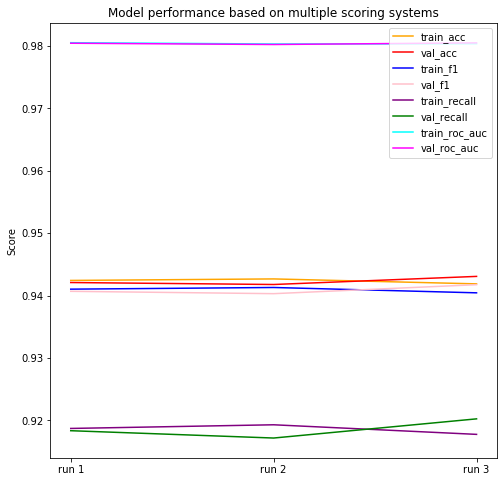

No special sampling
precision: 0.767
recall: 0.571
fscore: 0.655
roc_auc: 0.786
Accuracy: 0.999

Random over sampling
precision: 0.042
recall: 0.867
fscore: 0.079
roc_auc: 0.916
Accuracy: 0.965

Random over sampling
           Pred not fraud  Pred fraud
not fraud           54902        1962
fraud                  13          85


In [10]:
from imblearn.over_sampling import RandomOverSampler
#upsample minority class to create equal distribution of classes
rand_over_res = RandomOverSampler()
X_train_over_res, y_train_over_res = rand_over_res.fit_resample(X_train, y_train)

def evaluateResamplingMethod(results, X_train, y_train, X_test, y_test, resType=""):
    print("Label distribution:", y_train.value_counts()/y_train.count()*100)
    print("Number of instances:", y_train.count())


    results_over_res = crossValData(X_train, y_train)

    visualizeResults(results_over_res)
    compareResults(X_test, y_test, results, results_over_res, resType=resType) 

    print("\nRandom over sampling")
    print(pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=results_over_res["estimator"][-1].predict(X_test),
                                  labels=[0,1]),
                 columns = ["Pred not fraud","Pred fraud"],
                index = ["not fraud","fraud"]))
    
evaluateResamplingMethod(results, X_train_over_res, y_train_over_res, X_test, y_test, resType="Random over sampling")

## Be careful of re-sampling technique usages

Label distribution: 1    50.0
0    50.0
Name: Class, dtype: float64
Number of instances: 454902


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished


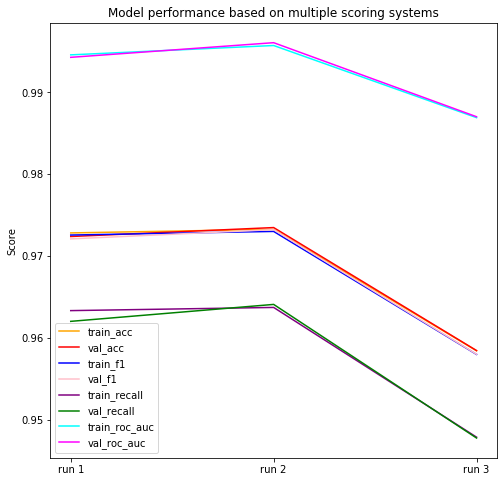

No special sampling
precision: 0.767
recall: 0.571
fscore: 0.655
roc_auc: 0.786
Accuracy: 0.999

Random over sampling
precision: 0.043
recall: 0.816
fscore: 0.083
roc_auc: 0.893
Accuracy: 0.969

Random over sampling
           Pred not fraud  Pred fraud
not fraud           55104        1760
fraud                  18          80


In [11]:
from imblearn.over_sampling import SMOTE
# Create artifical samples finding nearest neighbours + adding some slight disturabances to features
# Thus we can have almost "copies" of training set samples in validation set, improving perceived model performance
sm_over = SMOTE()
X_train_over_smote, y_train_over_smote = sm_over.fit_resample(X_train, y_train)
evaluateResamplingMethod(results, X_train_over_smote, y_train_over_smote,
                         X_test, y_test, resType="Random over sampling")

In [12]:
#Custom validation
for train_index, val_index in stratSplit.split(X_train, y_train):
    X_train_val = X_train.iloc[train_index]
    X_val = X_train.iloc[val_index]
    
    y_train_val = y_train.iloc[train_index]
    y_val = y_train.iloc[val_index]

print("y_train dist. before:")
print("Label distribution:\n", y_train_val.value_counts()/y_train_val.count()*100)
print("Number of instances:", y_train_val.count())
print()
X_train_res, y_train_res = rand_res.fit_resample(X_train_val, y_train_val)
X_train_over_res, y_train_over_res = rand_over_res.fit_resample(X_train_val, y_train_val)
X_train_over_smote, y_train_over_smote = sm_over.fit_resample(X_train_val, y_train_val)

def compareTrainValTestRecall(X_train, y_train, X_val, y_val, X_test, y_test):
    log_reg_res = LogisticRegression(C=1e5)
    log_reg_res.fit(X_train, y_train)
    print("y_val dist.:")
    print("Label distribution:\n", y_val.value_counts()/y_val.count()*100)
    print("Number of instances:", y_val.count())
    print("y_train dist.:")
    print("Label distribution:\n", y_train.value_counts()/y_train.count()*100)
    print("Number of instances:", y_train.count())
    for name, data, y_true in zip(["Train","Val","Test"],[X_train, X_val, X_test], [y_train, y_val, y_test]):
        y_pred = log_reg_res.predict(data)
        _,recall,_,_ = precision_recall_fscore_support(y_true=y_true,y_pred=y_pred)
        print(name,"recall:",round(recall[1],3))
    print()
    
print("random undersampling")
compareTrainValTestRecall(X_train_res, y_train_res, X_val, y_val, X_test, y_test)
print("random oversampling")
compareTrainValTestRecall(X_train_over_res, y_train_over_res, X_val, y_val, X_test, y_test)
print("SMOTE")
compareTrainValTestRecall(X_train_over_smote, y_train_over_smote, X_val, y_val, X_test, y_test)

y_train dist. before:
Label distribution:
 0    99.827185
1     0.172815
Name: Class, dtype: float64
Number of instances: 182276

random undersampling
y_val dist.:
Label distribution:
 0    99.826637
1     0.173363
Name: Class, dtype: float64
Number of instances: 45569
y_train dist.:
Label distribution:
 1    50.0
0    50.0
Name: Class, dtype: float64
Number of instances: 630
Train recall: 0.87
Val recall: 0.937
Test recall: 0.806

random oversampling
y_val dist.:
Label distribution:
 0    99.826637
1     0.173363
Name: Class, dtype: float64
Number of instances: 45569
y_train dist.:
Label distribution:
 1    50.0
0    50.0
Name: Class, dtype: float64
Number of instances: 363922
Train recall: 0.916
Val recall: 0.975
Test recall: 0.867

SMOTE
y_val dist.:
Label distribution:
 0    99.826637
1     0.173363
Name: Class, dtype: float64
Number of instances: 45569
y_train dist.:
Label distribution:
 1    50.0
0    50.0
Name: Class, dtype: float64
Number of instances: 363922
Train recall: 0.95